# Titanic prediction

Keras 入門題目，鐵達尼生存預測  
當作基本的classifier練習

[Titanic competition link](https://www.kaggle.com/c/titanic)




### Step1. 資料預處理  
首先把資料集利用pandas抓近來觀察  

In [37]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows',10)  

root = os.getcwd()
train_path = os.path.join(root,'titanic/train.csv')
test_path = os.path.join(root,'titanic/test.csv')

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [38]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## 資料描述

![](https://i.imgur.com/wYq0bGy.jpg)


這個訓練樣本數不多，只有900筆而已  
把訓練樣本與測試樣本合併，作為觀察與處理  

In [39]:
train_data['test_data'] = 0
test_data['test_data'] = 1
data = train_data.append(test_data,ignore_index=True,sort=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
test_data      1309 non-null int64
dtypes: float64(3), int64(5), object(5)
memory usage: 133.0+ KB


### Step2. 特徵工程

資料的處理有兩個處理方法  
其一是one hot encoding，如果資料為無序的，就會利用此方法對資料做編碼  
來把資料轉換維n維向量，讓其數據與原點的距離一致。  
  
另一個方法是當資料是有序的時候，直接數值化mapping資料  
讓每筆資料以一個數字表示，這會讓資料與原點距離不同。


需要觀察資料來確認特徵關聯性來決定資料的處理

#### 觀察生還與死亡

大約4成的人生存，可以用一般的logistic regresssion來做分類

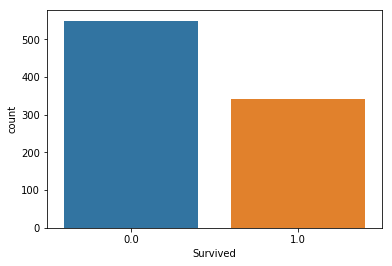

In [40]:
%matplotlib inline
sns.countplot(data['Survived'])

#### 觀察性別與生存關係  

女性生存的機率較高

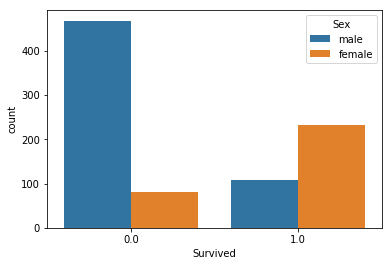

In [41]:
sns.countplot(data['Survived'],hue=data['Sex'])

#### 艙等與生存率關係
  
三等艙的死亡率較高，二等艙機率持平，一等艙生還率超過死亡率

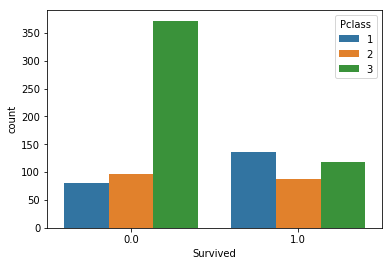

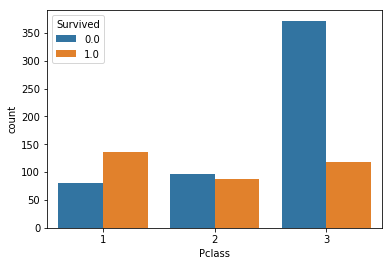

In [42]:
sns.countplot(data['Survived'],hue=data['Pclass'])
plt.figure()
sns.countplot(data['Pclass'],hue=data['Survived'])

#### 家庭成員關係

可以看到單身的人其死亡率較高，在有家庭成員下的死亡率趨近於相等
但是觀察性別在單身與否的狀況下發現其結果與觀察死亡性很像

藉由畫出組合的結果，可以發現在單身下，死亡的幾乎為男性
所以家庭成員這項要素可以視為冗餘的參數，暫時不需考慮進模型

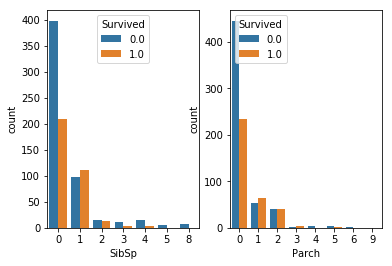

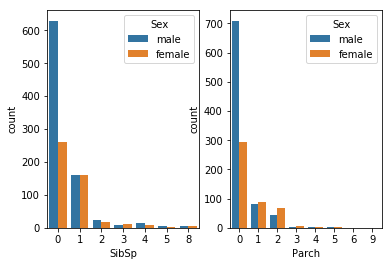

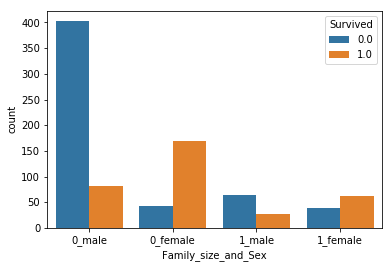

In [43]:
fig, [ax1,ax2] = plt.subplots(1,2)
sns.countplot(data['SibSp'],hue=data['Survived'],ax=ax1)
sns.countplot(data['Parch'],hue=data['Survived'],ax=ax2)


fig, [ax1,ax2] = plt.subplots(1,2)
sns.countplot(data['SibSp'],hue=data['Sex'],ax=ax1)
sns.countplot(data['Parch'],hue=data['Sex'],ax=ax2)


data['Family_size_and_Sex'] = (data['Parch']+data['SibSp']).map(lambda x : 1 if x >1 else 0).astype('str')+'_'+data['Sex']


plt.figure()
sns.countplot(data['Family_size_and_Sex'],hue=data['Survived'])

#### 年齡關係

可以觀察到年齡較輕者在生存率上較高

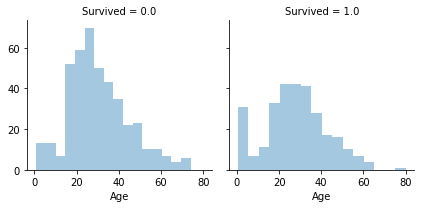

In [44]:
g= sns.FacetGrid(data,col='Survived')
g.map(sns.distplot,'Age',kde=False)

#### 票價

可以票價價低者的死亡率較高

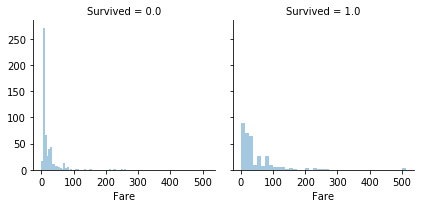

In [45]:
g= sns.FacetGrid(data,col='Survived')
g.map(sns.distplot,'Fare',kde=False)

#### 乘船處

乘船處對於死亡率的分布也是有關係的  
但是進一步把每個港口的上船性別分布拆開來看  
其實港口的差別只是因為性別關係帶來的影響  
可以視作這是一個冗餘的參數

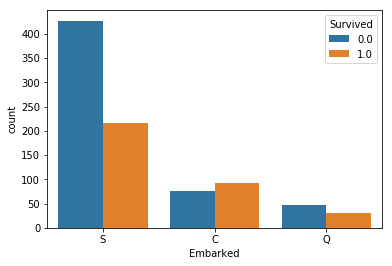

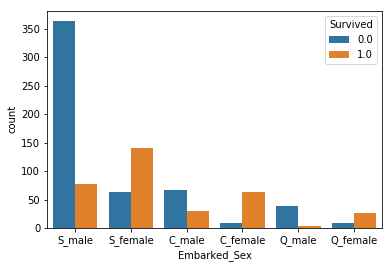

In [46]:
sns.countplot(data['Embarked'],hue=data['Survived'])

data['Embarked_Sex'] = data['Embarked']+'_'+data['Sex']
plt.figure()
sns.countplot(data['Embarked_Sex'],hue=data['Survived'], order=['S_male','S_female','C_male','C_female','Q_male','Q_female'])

#### 票等
票等看似在第三艙等也是有較高的死亡率  
但其實也是跟年齡呈現強烈相關  
這也是冗餘參數  

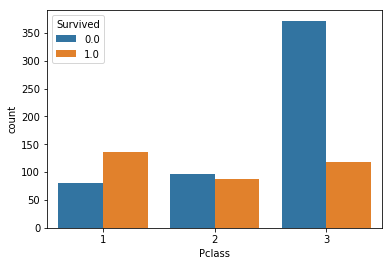

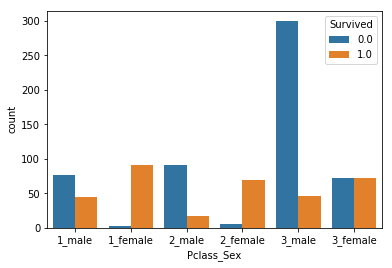

In [47]:
sns.countplot(data['Pclass'],hue=data['Survived'])
data['Pclass_Sex'] = data['Pclass'].astype('str')+'_'+data['Sex']

plt.figure()
sns.countplot(data['Pclass_Sex'],hue=data['Survived'], order=['1_male','1_female','2_male','2_female','3_male','3_female'])

#### 艙等
艙等情況與票等相像

['N' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


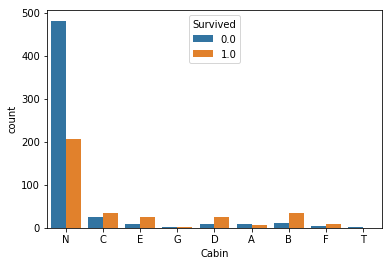

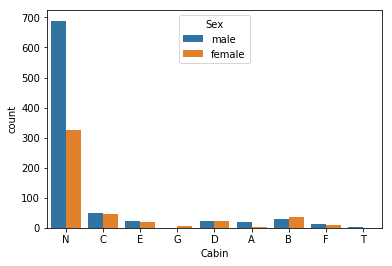

In [50]:
data['Cabin'] = data['Cabin'].apply(lambda x: str(x)[0] if not pd.isnull(x) else 'NoCabin')
print(data['Cabin'].unique())

sns.countplot(data['Cabin'],hue=data['Survived'])
plt.figure()
sns.countplot(data['Cabin'],hue=data['Sex'])

#### 姓名

姓名欄內都會有稱謂  
我們知道稱謂與年齡有相關性
因此我們利用稱謂來填補年齡

In [86]:
data['Title']=data['Name'].str.split(', ',n=0,expand=True)[1]
data['Title']=data['Title'].str.split('. ',n=0,expand=True)[0]
map_of_age = dict(data.groupby(['Title'])['Age'].median())

data['New_Age'] = data['Age'].map(lambda x: (data['Title'].map(map_of_age)) if pd.isnull(x) else x)

data['New_Age']

0                                                      22
1                                                      38
2                                                      26
3                                                      35
4                                                      35
                              ...                        
1304    0       29.0
1       35.5
2       22.0
3      ...
1305                                                   39
1306                                                 38.5
1307    0       29.0
1       35.5
2       22.0
3      ...
1308    0       29.0
1       35.5
2       22.0
3      ...
Name: New_Age, Length: 1309, dtype: object